# NFL Big Data Bowl 2020 - Data Exploration and Modelling

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import datetime
import re
import traceback

import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
sns.set()

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [9]:
KAGGLE_VERSION = False

## Read raw data

In [10]:
if KAGGLE_VERSION:
    data = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv')
else:
    data = pd.read_csv('train.csv')

D:\Blazej\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
data.shape

(509762, 49)

## Columns

Each row in the file corresponds to a single player's involvement in a single play. The dataset was intentionally joined (i.e. denormalized) to make the API simple. All the columns are contained in one large dataframe which is grouped and provided by PlayId. **This dataset only contains passing plays** (https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/111935#latest-645825)

* GameId - a unique game identifier
* PlayId - a unique play identifier
* Team - home or away
* X - player position along the long axis of the field. See figure below.
* Y - player position along the short axis of the field. See figure below.
* S - speed in yards/second
* A - acceleration in yards/second^2
* Dis - distance traveled from prior time point, in yards (by that player?)
* Orientation - orientation of player (deg)
* Dir - angle of player motion (deg)
* NflId - a unique identifier of the player
* DisplayName - player's name
* JerseyNumber - jersey number
* Season - year of the season<br>
The data is gathere from two seasons: 2017/2018 for which the value is 2017 and 2018/19 for which the value is 2018
* YardLine - the yard line of the line of scrimmage
* Quarter - game quarter (1-5, 5 == overtime)
* GameClock - time on the game clock<br>
The game clock starts at 15:00:00 at the beginning of every quarter and then goes until 00:00:00 when the quarter ends. Then the clock is reset to 15 mins when the new quarter starts.
* PossessionTeam - team with possession
* Down - the down (1-4)
* Distance - yards needed for a first down
* FieldPosition - which side of the field the play is happening on
* HomeScoreBeforePlay - home team score before play started
* VisitorScoreBeforePlay - visitor team score before play started
* NflIdRusher - the NflId of the rushing player<br>
Rushing, on offense, is running with the ball when starting from behind the line of scrimmage with an intent of gaining yardage. While this usually means a running play, any offensive play that does not involve a forward pass is a rush - also called a run. It is usually done by the running back after a handoff from the quarterback, although quarterbacks and wide receivers can also rush. The quarterback will usually run when a passing play has broken down – such as when there is no receiver open to catch the ball – and there is room to run down the field.
* OffenseFormation - offense formation
* OffensePersonnel - offensive team positional grouping
* DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
* DefensePersonnel - defensive team positional grouping
* PlayDirection - direction the play is headed
* TimeHandoff - UTC time of the handoff<br>
In American football, a hand-off is the act of handing the ball directly from one player to another, i. e. without it leaving the first player's hands.Most rushing plays on offense begin with a handoff from the quarterback to another running back.
* TimeSnap - UTC time of the snap <br>
A snap (colloquially called a "hike", "snapback", or "pass from center") is the backwards passing of the ballat the start of play from scrimmage.
* Yards - the yardage gained on the play (you are predicting this)
* PlayerHeight - player height (ft-in)
* PlayerWeight - player weight (lbs)
* PlayerBirthDate - birth date (mm/dd/yyyy)
* PlayerCollegeName - where the player attended college
* Position - the player's position (the specific role on the field that they typically play)
* HomeTeamAbbr - home team abbreviation
* VisitorTeamAbbr - visitor team abbreviation
* Week - week into the season
* Stadium - stadium where the game is being played
* Location - city where the game is being player
* StadiumType - description of the stadium environment
* Turf - description of the field surface
* GameWeather - description of the game weather
* Temperature - temperature (deg F)
* Humidity - humidity
* WindSpeed - wind speed in miles/hour
* WindDirection - wind direction
<img src="columns_visualization.png">
<img src="down_and_distance.png">

## Rules
I'm not familiar with american football, so at the beginning I want to understand what it's about for a better data exploration. The offence is given 4 chances (or 4 downs) to make at least 10 yards. If they do so, they retain the possesion and have another 4 chances to move 10 yards. Otherwise, the defending team gets the ball at that point

Each team usually consists of 3 units

* Offensive unit<br>
<img src="offensive_unit.png" width="400" align="left">

* Defensive unit<br>
<img src="defensive_unit.png" width="400" align="left">

* Special teams

There are 4 different ways of scoring:
1. Touchdown - 6 points - the ball is carried into the endzone or thrown into the endzone and caught
2. Extra points - after a touchdown is scored: kick through the uprights (1 point) or try to get the ball to the endzone again for 2 points (most team go for the kick)
3. Field goal - a ball must be passed to a player who will hold the ball at the ground ready for the kicker to make a kick, a successful kick scores 3 points
4. Safety - if the defense tackles the defensive player behind his own goal line, the defensive team gets 2 points

* Fumble - when the ball carrier drops the ball on the ground, the team that recovers it gets the posession.
* Interception - intercepting passes
* Sack - defense tackles the quarterback while he has the ball (down is wasted)
* Incomplete pass - when a pass touches the ground before reaching the receiver or goes out (down is wasted)
* Penalty - after a player makes a foul his team is penalized some yards
* Challenge - same as in tennis
* Timeout - each team has 3 timeouts per half, each timeout lasts 60 seconds
* Line of scrimmage - an imaginary transverse line (across the width of the football field) beyond which a team cannot cross until the next play has begun. Its location is based on the spot where the ball is placed after the end of the most recent play and following the assessment of any penalty yards.

## Data standardization
Source: https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python

In [12]:
data['ToLeft'] = data.PlayDirection == "left"
data['IsBallCarrier'] = data.NflId == data.NflIdRusher
data['Dir_rad'] = np.mod(90 - data.Dir, 360) * math.pi/180.0

# is that way more efficient?
data['TeamOnOffense'] = "home"
data.loc[data.PossessionTeam != data.HomeTeamAbbr, 'TeamOnOffense'] = "away"

data['IsOnOffense'] = data.Team == data.TeamOnOffense # Is player on offense?

data['YardLine_std'] = 100 - data.YardLine
data.loc[data.FieldPosition.fillna('') == data.PossessionTeam,  'YardLine_std'] = data.loc[data.FieldPosition.fillna('') == data.PossessionTeam, 'YardLine']

data['X_std'] = data.X
data.loc[data.ToLeft, 'X_std'] = 120 - data.loc[data.ToLeft, 'X'] 

data['Y_std'] = data.Y
data.loc[data.ToLeft, 'Y_std'] = 160/3 - data.loc[data.ToLeft, 'Y'] 

data['Dir_std'] = data.Dir_rad
data.loc[data.ToLeft, 'Dir_std'] = np.mod(np.pi + data.loc[data.ToLeft, 'Dir_rad'], 2*np.pi)

D:\Blazej\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in remainder
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Blazej\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in remainder


## Data cleaning

Let's first clean the values to make the job easier for the model.

### Cleaning categorical variables

In [13]:
# data.select_dtypes(include='object').columns

#### Cleaning team names

In [15]:
teams = {'ARI':'ARZ','BAL':'BLT','CLE':'CLV', 'HOU':'HST'}

for old_name in teams:
    new_name = teams[old_name]
    data.replace(old_name, new_name, inplace=True)

#### Cleaning stadium names

In [16]:
stadiums =  {'Broncos Stadium at Mile High':'Broncos Stadium At Mile High','CenturyLink':'CenturyLink Field',
             'CenturyField':'CenturyLink Field','Everbank Field':'EverBank Field', 'First Energy Stadium':'FirstEnergy Stadium',
            'FirstEnergy':'FirstEnergy Stadium','FirstEnergyStadium':'FirstEnergy Stadium', 'Lambeau field':'Lambeau Field',
             'Los Angeles Memorial Coliesum':'Los Angeles Memorial Coliseum','M & T Bank Stadium':'M&T Bank Stadium',
            'M&T Stadium':'M&T Bank Stadium','Mercedes-Benz Dome':'Mercedes-Benz Stadium','MetLife':'MetLife Stadium',
            'Metlife Stadium':'MetLife Stadium','NRG':'NRG Stadium','Oakland Alameda-County Coliseum':'Oakland-Alameda County Coliseum',
            'Paul Brown Stdium':'Paul Brown Stadium', 'Twickenham':'Twickenham Stadium'}

for old_name in stadiums:
    new_name = stadiums[old_name]
    data.replace(old_name, new_name, inplace=True)

#### Cleaning stadium types

In [17]:
isOpen = data['StadiumType'].str.contains('open', case=False) | data['StadiumType'].str.contains('outdoor', case=False)
isClosed = data['StadiumType'].str.contains('closed', case=False) | data['StadiumType'].str.contains('indoor', case=False)

data.loc[isOpen,'StadiumType'] = 'Open'
data.loc[isClosed,'StadiumType'] = 'Closed'

data.loc[data['Stadium']=="TIAA Bank Field",'StadiumType'] = 'Open'
data.loc[data['Stadium']=="StubHub Center",'StadiumType'] = 'Open'
data.loc[data['Stadium']=='MetLife Stadium','StadiumType'] = 'Open'


stadium_types = {"Heinz Field":"Open","Dome":"Retractable Roof","Outddors":"Open","Oudoor":"Open",
                 "Ourdoor":"Open","Outdor":"Open","Outside":"Open","Domed":"Closed"}

for old_name in stadium_types:
    new_name = stadium_types[old_name]
    data.replace(old_name, new_name, inplace=True)

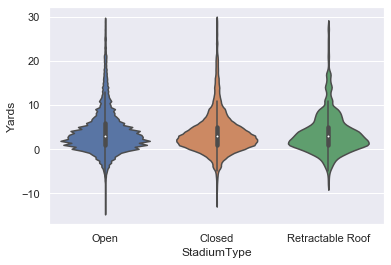

In [18]:
sns.violinplot(x="StadiumType", y='Yards', data=data[data['Yards']<30])

The violinplots for all three values seem roughly the same, so it does not seem that the StadiumType variables will be very helpful

There are some duplicates and typos in Location, let's fix the typos and split it into city and state

#### Cleaning Location

In [19]:
locations = {'Orchard Park NY':'Orchard Park, NY','Orchard Park':'Orchard Park, NY','Chicago. IL':'Chicago, IL',
             'Cleveland Ohio':'Cleveland, OH', 'Jacksonville Florida':'Jacksonville, FL','Pittsburgh':'Pittsburgh, PA',
            'Detroit':'Detroit, MA','London':'London, England',
        'Mexico City':'Mexico City, Mexico','Seattle':'Seattle, WA','Cleveland':'Cleveland, OH', 'New Orleans':'New Orleans, LA'}

for old_name in locations:
    new_name = locations[old_name]
    data.replace(old_name, new_name, inplace=True)
    
location = data['Location'].str.split(',', expand=True)
data['City'] = location[0]
data['State'] = location[1].str.strip()

states = {'Calif.':'CA','FLA':'FL','Fl':'FL','Fla.':'FL','Florida':'FL', 'Ind.':'IN','La.':'LA','Ma':'MA','Maryland':'MA',
         'Md.':'MD', 'N.J.':'NJ', 'North Carolina':'NC', 'Ohio':'OH', 'Pa.':'PA','Texas':'TX'}

for old_name in states:
    new_name = states[old_name]
    data.replace(old_name, new_name, inplace=True)

I wasn't certain about the PlayerCollegeName column so I left it intact for now. Maybe creating a variable indicating in which state the player went to college could be helpful. Position looks sort of clean. I would like to experiment by building the same models based on different positions, so for example only model based on QBs and only on TEs and so on. This would indicate which position's data is the most important.

First standardize the directions according to 16-point compass rose. Then maybe make features like if player runs against the wind. However, for that we would need orientation of the stadium.

<img src="Compass_Rose_English_North.svg.png" width=200 align=left>

#### Cleaning WindDirection

In [21]:
wind_directions = {'South':'S','North':'N','West':'W', 'East':'E','Northwest':'NW','SouthWest':'SW','Northeast':'NE','From S':'S',
     'South Southeast':'SSE','From SW':'SW','s':'S', 'NorthEast':'NE','from W':'W', 'W-NW':'WNW','South Southwest':'SSW',
     'Southeast':'SE','From WSW':'WSW', 'West Northwest':'WNW','From SSE':'SSE','From W':'W', 'East North East':'ENE',
     'From ESE':'ESE','EAST':'E','East Southeast':'ESE','From SSW':'SSW','North East':'NE', 'Southwest':'SW', 
     'North/Northwest':'NNW', 'From NNE':'NNE','N-NE':'NNE','W-SW':'WSW', 'From NNW':'NNW','West-Southwest':'WSW',
     'Calm':'Missing','8':'Missing','1':'Missing','13':'Missing'}

for old_name in wind_directions:
    new_name = wind_directions[old_name]
    data.replace(old_name, new_name, inplace=True)
    
data.loc[(data['WindDirection'].isna()),'WindDirection'] = 'Missing'

It's quite cumbersome to change the type to int due to NaNs, so to avoid the trouble, I changed the type to float.

#### Cleaning WindSpeed

In [22]:
data.loc[data['WindSpeed']=='14-23','WindSpeed'] = 18
data.loc[data['WindSpeed']=='11-17','WindSpeed'] = 16
data.loc[data['WindSpeed']=='12-22','WindSpeed'] = 17
data.loc[data['WindSpeed']=='15 gusts up to 25','WindSpeed'] = 20
# some WindSpeed values contains characters, so below we just extract the numbers, e.g."15 MPH" will be changed to 15
data['WindSpeed'] = data['WindSpeed'].astype(str).str.extract('(\d+)')[0].astype(float)

#### Cleaning GameWeather

In [23]:
rainy = ['Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy, 50% change of rain','Cloudy, Rain','Light Rain','Rain','Rain Chance 40%', 
         'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 'Scattered Showers', 'Showers',]
clear = ['Clear','Clear Skies','Clear and Cool','Clear and Sunny','Clear and cold','Clear and sunny','Clear and warm',
         'Clear skies','Partly clear',]
snowy = ['Cloudy, light snow accumulating 1-3"','Heavy lake effect snow','Snow']
sunny = ['Mostly Sunny', 'Mostly Sunny Skies','Mostly sunny','Partly Sunny','Partly sunny','Sunny',
 'Sunny Skies', 'Sunny and clear', 'Sunny and cold', 'Sunny and warm', 'Sunny, Windy', 'Sunny, highs to upper 80s',]
cloudy = ['30% Chance of Rain','Cloudy', 'Cloudy and Cool', 'Cloudy and cold','Cloudy, chance of rain',
          'Cloudy, fog started developing in 2nd quarter','Coudy','Mostly Cloudy','Mostly Coudy','Mostly cloudy',
          'Overcast','Partly Cloudy','Partly Clouidy','Partly cloudy','Party Cloudy','Sun & clouds','cloudy']

data['GameWeatherGrouped'] = 'Other'
data.loc[data['StadiumType']=='Closed','GameWeatherGrouped'] = 'Indoor'
data.loc[data['GameWeather'].isin(rainy),'GameWeatherGrouped'] = 'Rainy'
data.loc[data['GameWeather'].isin(clear),'GameWeatherGrouped'] = 'Clear'
data.loc[data['GameWeather'].isin(snowy),'GameWeatherGrouped'] = 'Snowy'
data.loc[data['GameWeather'].isin(sunny),'GameWeatherGrouped'] = 'Sunny'
data.loc[data['GameWeather'].isin(cloudy),'GameWeatherGrouped'] = 'Cloudy'

#### Cleaning Turf - add a isNatural column

In [24]:
data['isNatural'] = False
isNatural = data['Turf'].str.contains('natural', case=False) | data['Turf'].str.contains('grass', case=False)
data.loc[isNatural,'isNatural'] = True
data.loc[isNatural,'Turf'] = 'Natural grass'

turfs = {'Artifical':'Artificial','Field Turf':'FieldTurf','Field turf':'FieldTurf','FieldTurf360':'FieldTurf 360',
        'UBU Sport Speed S5-M':'UBU Speed Series-S5-M'}

for old_name in turfs:
    new_name = turfs[old_name]
    data.replace(old_name, new_name, inplace=True)

#### Parsing PlayerBirthDate to datetime and adding Age variable

data['PlayerBirthDate'] = pd.to_datetime(data['PlayerBirthDate'],format='%m/%d/%Y')

current = datetime.datetime(2019, 11, 1)

data['PlayerAge'] = (current-data['PlayerBirthDate']).apply(lambda x: int(x.days/365))

#### Converting player height from string in feet to centimeters

In [25]:
height_feet = data['PlayerHeight'].str.split('-',expand=True)
data['PlayerHeightCm'] = 30.48*height_feet[0].astype(float)+2.54*height_feet[1].astype(float)

#### Converting GameClock which is relative to the quarter to TimeElapsed that is relative to the whole game

In [26]:
game_clock = data['GameClock'].str.split(':', expand=True)
data['TimeElapsed'] = data['Quarter']*15*60+game_clock[0].astype(int)*60+game_clock[1].astype(int)

In [27]:
data['GameClock'] = pd.to_datetime(data['GameClock'].str.slice(0,5), format='%M:%S')

### Column candidates for removal
FieldPosition indicates on which team's half the play is happening. Probably it can be deleted, but let's leave it for now. After executing the code below, the attacking team will always attack from left to right. Therefore, we can probably delete the PlayDirection column. DisplayName which is player name is also redundant for training because we already have NflId.

In [28]:
# data.to_csv("train_cleaned.csv")

## Data exploration

In [29]:
# data = pd.read_csv("train_cleaned.csv")

In [30]:
# data.shape

In [31]:
score_col = ['HomeScoreBeforePlay','VisitorScoreBeforePlay']

In [32]:
data['OffenseFormation'].unique()

array(['SHOTGUN', 'SINGLEBACK', 'JUMBO', 'PISTOL', 'I_FORM', 'ACE',
       'WILDCAT', nan, 'EMPTY'], dtype=object)

Maybe splitting the OffensePersonnel variable into objects could improve the score.

In [33]:
offense_formations = data['OffensePersonnel'].unique()
print('Possible offensive positions',list(set(re.findall('[A-Z]+',offense_formations.sum()))))

Possible offensive positions ['LB', 'DL', 'WR', 'TE', 'RB', 'DB', 'QB', 'OL']


In [34]:
positions = ['OL', 'QB', 'RB', 'TE', 'WR', 'DL', 'DB','LB']
nr_positions = ['Offense #'+pos for pos in positions]

for pos in nr_positions: data[pos] = 0

for formation in offense_formations:
    pos_list = [p.strip() for p in formation.split(',')]
#     print(pos_list)
    df_values = np.zeros(len(positions),int)
    for pos in pos_list:
        for i, p in enumerate(positions):
            if p in pos:
                df_values[i] = pos[0]
    if 'QB' not in formation:
        df_values[1] = 1
    if 'OL' not in formation:
        df_values[0] = 11-sum(df_values)
    data.loc[data['OffensePersonnel']==formation, nr_positions] = df_values
#     print('Formation',formation)

In [49]:
data[['OffensePersonnel']+nr_positions].drop_duplicates(subset='OffensePersonnel')

,OffensePersonnel,Defense #DL,Defense #OL,Defense #DB,Defense #LB
0,"1 RB, 1 TE, 3 WR",2,0,6,3
66,"6 OL, 2 RB, 2 TE, 0 WR",4,0,3,4
88,"1 RB, 3 TE, 1 WR",3,0,6,2
132,"1 RB, 2 TE, 2 WR",3,0,4,4
154,"6 OL, 1 RB, 2 TE, 1 WR",3,0,4,4
176,"2 RB, 1 TE, 2 WR",3,0,6,2
418,"2 RB, 2 TE, 1 WR",3,0,4,4
550,"0 RB, 3 TE, 2 WR",3,0,6,2
572,"0 RB, 1 TE, 4 WR",3,0,6,2
1628,"6 OL, 1 RB, 0 TE, 3 WR",4,0,5,2


In [36]:
# data['FieldPosition'].unique()

Same remarks as for offense

In [37]:
defense_formations = data['DefensePersonnel'].unique()
print('Possible defensive positions',list(set(re.findall('[A-Z]+',defense_formations.sum()))))

Possible defensive positions ['OL', 'LB', 'DB', 'DL']


In [38]:
positions = ['DL', 'OL', 'DB', 'LB']
nr_positions = ['Defense #'+pos for pos in positions]

for pos in nr_positions: data[pos] = 0

for formation in defense_formations:
    pos_list = [p.strip() for p in formation.split(',')]
    df_values = np.zeros(len(positions),int)
    for pos in pos_list:
        for i, p in enumerate(positions):
            if p in pos:
                df_values[i] = pos[0]
    data.loc[data['DefensePersonnel']==formation, nr_positions] = df_values
#     print('Formation',formation)

In [50]:
data[['DefensePersonnel']+nr_positions].drop_duplicates(subset='DefensePersonnel').head()

,DefensePersonnel,Defense #DL,Defense #OL,Defense #DB,Defense #LB
0,"2 DL, 3 LB, 6 DB",2,0,6,3
66,"4 DL, 4 LB, 3 DB",4,0,3,4
88,"3 DL, 2 LB, 6 DB",3,0,6,2
132,"3 DL, 4 LB, 4 DB",3,0,4,4
286,"3 DL, 3 LB, 5 DB",3,0,5,3


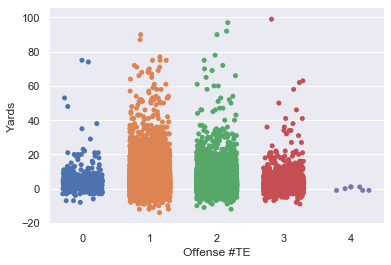

In [40]:
import matplotlib.pyplot as plt
# plt.figure(figsize = (20,20))
s = data.drop_duplicates(subset='PlayId')
sns.stripplot(x='Offense #TE', y='Yards',data=s,jitter=.3)

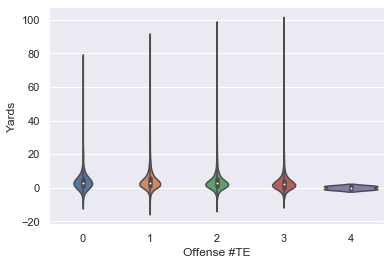

In [41]:
sns.violinplot(x='Offense #TE', y='Yards',data=s,jitter=.3)

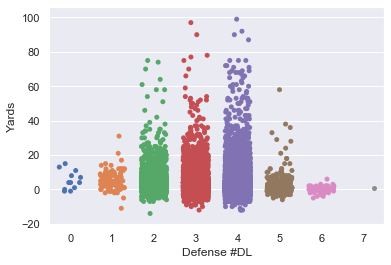

In [42]:
sns.stripplot(x='Defense #DL', y='Yards',data=s,jitter=.3)

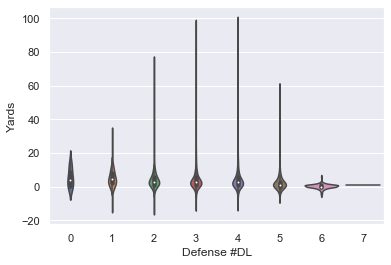

In [43]:
sns.violinplot(x='Defense #DL', y='Yards',data=s)

In [ ]:
# data.to_csv('train_cleaned_formations.csv', index=False)

In [44]:
data[data['Yards']<0].shape[0]/data.shape[0]

0.11052608864528937

In 11% of plays the offensive team looses yards instead of gaining

In [45]:
# data['Yards'].describe()

In [46]:
# sns.distplot(data['Yards'])

In [47]:
# team name of the player
data['TeamName'] = np.where(data['Team']=='away', data['VisitorTeamAbbr'], data['HomeTeamAbbr'])

In [48]:
# data.shape

Now we add additional feature which is the distance from the rusher to the closest opponent. This might help to improve the prediction.

In [ ]:
def closestOpponent(x):
    coords = ['X_std','Y_std']
#     get rusher index
    rusher_ix = x[x['NflId']==x['NflIdRusher']].index[0]
#     get rusher X and Y
    rusher_coords = data.at[rusher_ix,'X_std'],data.at[rusher_ix,'Y_std']
#     get coords of defensive team
    defensive_team_coords = x[x['PossessionTeam']!=x['TeamName']][coords]
#     get euclidean distance between each deffense team player and the rusher
    euclideanDis = (defensive_team_coords-rusher_coords).pow(2).sum(1).pow(0.5)
#     get minimal distance to the rusher
    return euclideanDis.min()

d = data.groupby(by='PlayId').apply(closestOpponent)

data['ClosestOpponent'] = [d[x] for x in data['PlayId']]

https://www.data-to-viz.com/caveat/overplotting.html

In [ ]:
x = data['ClosestOpponent']
y = data['Yards']
h = plt.hist2d(x, y)
plt.colorbar(h[3])

In [ ]:
# a = sns.jointplot(x='ClosestOpponent', y='Yards',data=data, kind='hex')

In [ ]:
# rushers = data[data.NflId==data.NflIdRusher].copy()
# rushers['DistRushScrimmage'] = (rushers['YardLine_std']+10-rushers['X_std']).abs()

In [ ]:
# sns.distplot(rushers['DistRushScrimmage'])

In [ ]:
# rushers['DistRushScrimmage'].describe()

In [ ]:
# sns.scatterplot(x='Yards', y='DistRushScrimmage', data=rushers)

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize = (30,30))

# sns.heatmap(data.corr(),vmin=-1,vmax=1,center=0,annot=True)
# # plt.show()

I was expecting a linear relationship but boy was I wrong

In [ ]:
# data['YardLine_std'].describe()

In [ ]:
# data.to_csv('train_proc.csv',index=False)

## TO DO
* Check if it's more difficult to gain yardage close to the defensive team endzone
* Prediction processing trick: Remember that the yards gained cant be more than length of the field - line of scrimmage!
* Prediction processing trick: For rows with the same PlayId, the Yards must be the same
* Get a better intuition what the Dis variables really is, try plotting the points
* Try to visualize from the data what happened in the game, retrieve touchdowns, fumbles, interceptions etc. Verify it with a match, you can watch all matches on youtube https://www.youtube.com/channel/UCP4Wts8iiR9-Ddfq7FK0x3g/videos


## Read processed data

In [ ]:
from kaggle.competitions import nflrush
env = nflrush.make_env()

In [ ]:
import os
os.listdir('../../kaggle')

In [ ]:
import pandas as pd
# data = pd.read_csv('../../kaggle/output/working/train_proc.csv')
data = data.drop(['GameClock','PlayerBirthDate'],axis=1)

In [ ]:
from sklearn.model_selection import GroupKFold
cat_vars = data.select_dtypes(include='object').columns
cont_vars = data.select_dtypes(exclude='object').columns
print(cat_vars)
print(cont_vars)
cont_medians = {}
for col in cont_vars:
    print(col)
    data[col] = data[col].fillna(data[col].median())
    cont_medians[col] = data[col].median()

for col in cat_vars:
    data[col] = data[col].fillna('Missing')    

from sklearn.preprocessing import LabelEncoder

le_dict = {}
for col in cat_vars:
    le = LabelEncoder()
    le.fit(list(set(data[col].values))+['Missing'])
    le_dict[col] = le
    data[col] = le.transform(data[col])
#     test[col] = le.transform(list(test[col].astype(str).values))   

In [ ]:
from sklearn.metrics import mean_squared_error

models = []
def train_model(X, y, folds, model_type='lgb', eval_metric='auc', n_jobs=-1, n_estimators=None, plot_feature_importance=True, verbose=500,early_stopping_rounds=200):
    result_dict = {}
    scores = []
    n_splits = folds.n_splits
    columns = X.columns
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), 1))
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y,X['GameId'])):
        print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model = lgb.LGBMRegressor(n_estimators=n_estimators, n_jobs = n_jobs)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        models.append(model)
        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        oof[valid_index] = y_pred.reshape(-1, 1)
        scores.append(rmse)
    
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].reset_index(level=['feature'])


            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features);
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict

In [ ]:
rushers = data[data.NflId==data.NflIdRusher]

In [ ]:
import matplotlib.pyplot as plt
X = rushers.drop(['Yards'],axis=1)
y = rushers['Yards']
folds = GroupKFold(n_splits=5)
results = train_model(X, y, folds, n_estimators=1000) # a, s, clos, dirstd,gamecloc, dir,orient, x, time

In [ ]:

import tqdm
test_dfs = pd.DataFrame(columns=X.columns)
for (test_df, sample_prediction_df) in tqdm.tqdm(env.iter_test()):
    test_df1 = test_df.copy()
    
    for old_name in teams:
        new_name = teams[old_name]
        test_df.replace(old_name, new_name, inplace=True)
    
    test_df['ToLeft'] = test_df.PlayDirection == "left"
    test_df['X_std'] = test_df.X
    test_df.loc[test_df.ToLeft, 'X_std'] = 120 - test_df.loc[test_df.ToLeft, 'X'] 
    
    test_df['Y_std'] = test_df.X
    test_df.loc[test_df.ToLeft, 'Y_std'] = 160/3 - test_df.loc[test_df.ToLeft, 'Y'] 
    
    test_df['TeamName'] = np.where(test_df['Team']=='away', test_df['VisitorTeamAbbr'], test_df['HomeTeamAbbr'])
    
    test_df['ClosestOpponent'] = closestOpponent(test_df)
    test_df = test_df[test_df.NflId == test_df.NflIdRusher]
    test_df = test_df.iloc[0]
    
    test_df['ToLeft'] = test_df.PlayDirection == "left"
    test_df['IsBallCarrier'] = test_df.NflId == test_df.NflIdRusher
    test_df['Dir_rad'] = np.mod(90 - test_df.Dir, 360) * math.pi/180.0

    if test_df.PossessionTeam != test_df.HomeTeamAbbr:
        test_df['TeamOnOffense'] = "away"
    else:
        test_df['TeamOnOffense'] = "home"
        
    test_df['IsOnOffense'] = test_df.Team == test_df.TeamOnOffense # Is player on offense?

    
    if test_df.FieldPosition == test_df.PossessionTeam:
        test_df['YardLine_std'] = test_df['YardLine']
    else:
        test_df['YardLine_std'] = 100 - test_df.YardLine
    
    
    if test_df['ToLeft']:
#         test_df['X_std'] = 120 - test_df.loc['X'] 
#         test_df.loc['Y_std'] = 160/3 - test_df['Y']
        test_df['Dir_std'] = np.mod(np.pi + test_df['Dir_rad'], 2*np.pi)
    else:
#         test_df['X_std'] = test_df.X
#         test_df['Y_std'] = test_df.Y
        test_df['Dir_std'] = test_df.Dir_rad
        

    
    if test_df.Stadium in stadiums:
        test_df.Stadium = stadiums[test_df.Stadium]
    elif test_df.Stadium not in data.Stadium.unique():
        test_df.Stadium = 'Missing'
    # Cleaning stadium types
    try:
        isOpen = test_df['StadiumType'].str.contains('open', case=False) | test_df['StadiumType'].str.contains('outdoor', case=False)
        isClosed = test_df['StadiumType'].str.contains('closed', case=False) | test_df['StadiumType'].str.contains('indoor', case=False)
        print('isOpen {} isClosed {}'.format(isOpen,isClosed))

        if isOpen or test_df['Stadium']=="TIAA Bank Field" or test_df['Stadium']=="StubHub Center" or test_df['Stadium']=='MetLife Stadium':
            test_df['StadiumType'] = 'Open'
        elif isClosed:
            test_df.loc['StadiumType'] = 'Closed'
        elif test_df.StadiumType in stadium_types:
            test_df.StadiumType = stadium_types[test_df.StadiumType]
            
    except Exception:
        traceback.print_exc()
        test_df['StadiumType'] = 'Missing'

    
    if test_df.Location in locations:
        test_df.Location = locations[test_df.Location]
    elif test_df.Location not in data.Location.unique():
        test_df.Location = 'Missing'
#         /here
        
    
    try:
        location = test_df['Location'].split(',')
        test_df['City'] = location[0]
        test_df['State'] = location[1].strip()
    except Exception:
        traceback.print_exc()
        test_df['City'] = 'Missing'
        test_df['State'] = 'Missing'


    if test_df.State in states:
        test_df.State = states[test_df.State]

    if test_df.WindDirection in wind_directions:
        test_df.WindDirection = wind_directions[test_df.WindDirection]
    elif test_df.WindDirection not in data.WindDirection.unique():
        test_df.WindDirection = 'Missing'

    wind_speed = {'14-23':18,'11-17':16,'12-22':17,'15 gusts up to 25':20}

    if test_df.WindSpeed in wind_speed:
        test_df.WindSpeed = wind_speed[test_df.WindSpeed]
    else:
        try:
            # some WindSpeed values contains characters, so below we just extract the numbers, e.g."15 MPH" will be changed to 15
            test_df['WindSpeed'] = float(re.findall('(\d+)',str(test_df['WindSpeed']))[0])
        except Exception:
            traceback.print_exc()
            test_df['WindSpeed'] = np.nan
            
    if test_df.StadiumType=='Closed':
        test_df['GameWeatherGrouped'] = 'Indoor'
    elif test_df.GameWeather in rainy:
        test_df['GameWeatherGrouped'] = 'Rainy'
    elif test_df.GameWeather in clear:
        test_df['GameWeatherGrouped'] = 'Clear'
    elif test_df.GameWeather in snowy:
        test_df['GameWeatherGrouped'] = 'Snowy'
    elif test_df.GameWeather in sunny:
        test_df['GameWeatherGrouped'] = 'Sunny'
    elif test_df.GameWeather in cloudy:
        test_df['GameWeatherGrouped'] = 'Cloudy'
    else:
        test_df['GameWeatherGrouped'] = 'Other'



    isNatural = 'natural' in test_df['Turf'].lower() or 'grass' in test_df['Turf'].lower()
    test_df['isNatural'] = isNatural
    print(test_df.isNatural)
    if isNatural:
        test_df['Turf'] = 'Natural grass'
    elif test_df.Turf in turfs:
        test_df.Turf = turfs[test_df.Turf]
    elif test_df.Turf not in data.Turf.unique():
        test_df.Turf = 'Missing'

    test_df['PlayerBirthDate'] = pd.to_datetime(test_df['PlayerBirthDate'],format='%m/%d/%Y')

    test_df['PlayerAge'] = int((current-test_df['PlayerBirthDate']).days/365)

    # Converting player height from string in feet to centimeters
    height_feet = test_df['PlayerHeight'].split('-')
    test_df['PlayerHeightCm'] = 30.48*float(height_feet[0])+2.54*float(height_feet[1])

    # Converting GameClock which is relative to the quarter to TimeElapsed that is relative to the whole game
    game_clock = test_df['GameClock'].split(':')
    test_df['TimeElapsed'] = test_df['Quarter']*15*60+int(game_clock[0])*60+int(game_clock[1])

    # doubt
    test_df = test_df.drop(['GameClock','PlayerBirthDate'])
    #     test_df['GameClock'] = pd.to_datetime(test_df['GameClock'].str.slice(0,5), format='%M:%S')
    positions = ['OL', 'QB', 'RB', 'TE', 'WR', 'DL', 'DB','LB']
    nr_positions = ['Offense #'+pos for pos in positions]

    for pos in nr_positions: test_df[pos] = 0
    #     offense_formations = test_df['OffensePersonnel'].unique()
    #     print('Possible offensive positions',list(set(re.findall('[A-Z]+',offense_formations.sum()))))
    formation =test_df['OffensePersonnel']
    pos_list = [p.strip() for p in formation.split(',')]
    df_values = np.zeros(len(positions),int)
    for pos in pos_list:
        for i, p in enumerate(positions):
            if p in pos:
                df_values[i] = pos[0]
    if 'QB' not in formation:
        df_values[1] = 1
    if 'OL' not in formation:
        df_values[0] = 11-sum(df_values)
    test_df[nr_positions] = df_values

    #     print('Formation',formation)
    #     defense_formations = test_df['DefensePersonnel'].unique()
    #     print('Possible defensive positions',list(set(re.findall('[A-Z]+',defense_formations.sum()))))
    positions = ['DL', 'OL', 'DB', 'LB']
    nr_positions = ['Defense #'+pos for pos in positions]

    for pos in nr_positions: test_df[pos] = 0 
    formation = test_df['DefensePersonnel']
    pos_list = [p.strip() for p in formation.split(',')]
    df_values = np.zeros(len(positions),int)
    for pos in pos_list:
        for i, p in enumerate(positions):
            if p in pos:
                df_values[i] = pos[0]
    test_df[nr_positions] = df_values

    test_df = pd.DataFrame(test_df).transpose()
    for col in cont_vars:
        if col!='Yards':
            test_df[col] = test_df[col].fillna(cont_medians[col])
    for col in cat_vars:
        test_df[col] = test_df[col].fillna('Missing')
        
    test_dfs = test_dfs.append(test_df)
    from sklearn.preprocessing import LabelEncoder
    for col in cat_vars:
        try:
            test_df[col] = le_dict[col].transform(test_df[col])
        except Exception:
            traceback.print_exc()
            test_df[col] = 'Missing'
            test_df[col] = le_dict[col].transform(test_df[col])
    #     test[col] = le_dict[col].transform(list(test[col].astype(str).values)) 
    
    folds = 5
    y_pred_p = np.sum(np.round([model.predict(test_df)[0] for model in models]))/folds
    y_pred = np.zeros(199) 
    y_pred_p += 99
    for j in range(199):
        if j>=y_pred_p+10:
            y_pred[j]=1.0
        elif j>=y_pred_p-10:
            y_pred[j]=(j+10-y_pred_p)*0.05
    env.predict(pd.DataFrame(data=[y_pred],columns=sample_prediction_df.columns))
env.write_submission_file()
test_dfs.to_csv('test_dfs.csv')
